# Imports and Setup

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# Display config
pd.set_option("display.max_colwidth", 200)
sns.set(style="whitegrid")

# Load Reduced Embeddings

In [27]:
X_reduced = pd.read_csv("../data/tfidf_reduced_50d.csv", index_col=0)

# Confirm shape and structure
print("Shape:", X_reduced.shape)
X_reduced.head()


Shape: (60, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
ticket_id,,,,,,,,,,,,,,,,,,,,,
1,0.210761,-0.157268,0.064795,-0.234947,0.055125,0.021271,0.362495,-0.182535,0.166877,-0.201897,...,0.003563,-0.081035,-0.065605,0.088537,-0.009857,-0.020826,0.054340,-0.002085,0.025076,-0.009775
2,0.048826,0.076185,0.105711,-0.057489,0.684273,-0.371124,0.012445,-0.074571,0.023148,0.100741,...,-0.054195,-0.008016,0.001179,0.029992,0.089005,0.031441,0.020409,-0.061217,0.028418,0.027213
3,0.124240,0.717688,0.008947,-0.434106,-0.170964,0.010172,-0.045533,0.124265,0.160163,-0.048867,...,-0.018755,0.020690,-0.019852,0.016610,0.000931,0.014594,-0.003268,0.000196,-0.004846,0.004219
4,0.005271,0.077218,0.830302,0.194218,-0.111303,0.031174,0.014802,-0.009186,0.000372,0.000429,...,0.092240,-0.137175,0.067342,-0.065735,0.045687,0.041612,-0.030272,-0.029424,0.003843,0.006396
5,0.034906,0.189768,0.087777,-0.144170,0.071617,0.035836,-0.025256,0.074693,-0.215976,0.060275,...,-0.035920,0.016460,0.008162,-0.012003,0.010103,0.026724,-0.020038,-0.022375,0.004483,0.007504


# KMeans Elbow Method

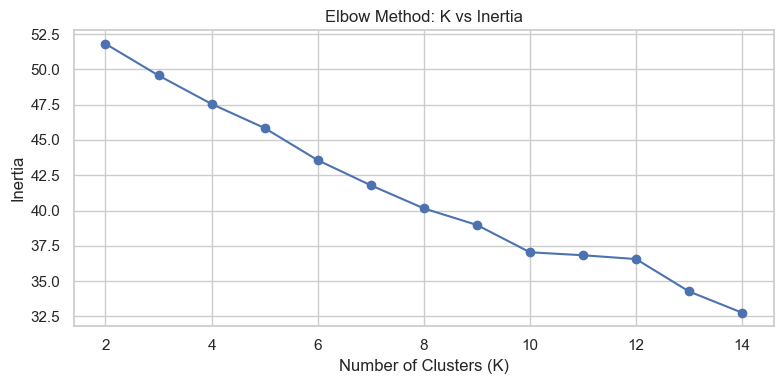

In [28]:
from sklearn.cluster import KMeans

inertias = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_reduced)
    inertias.append(km.inertia_)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method: K vs Inertia")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

In [29]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(X_reduced)

# Add labels to DataFrame
X_reduced["kmeans_cluster"] = labels_kmeans

# Preview cluster assignments
X_reduced["kmeans_cluster"].value_counts().sort_index()

kmeans_cluster
0     6
1     4
2     4
3     5
4     4
5     5
6     4
7    17
8     6
9     5
Name: count, dtype: int64

## Evaluate KMneans Clustering

In [30]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_reduced.drop(columns="kmeans_cluster"), labels_kmeans)
print(f"Silhouette Score (KMeans, k=10): {score:.4f}")

Silhouette Score (KMeans, k=10): 0.0784


# HDBSCAN

In [31]:
import hdbscan

# Initialize model — you can tune min_cluster_size
hdb = hdbscan.HDBSCAN(min_cluster_size=2, prediction_data=True)
labels_hdb = hdb.fit_predict(X_reduced.drop(columns="kmeans_cluster"))

# Add HDBSCAN cluster labels (label -1 = noise)
X_reduced["hdbscan_cluster"] = labels_hdb

# Show counts
X_reduced["hdbscan_cluster"].value_counts().sort_index()

hdbscan_cluster
-1    39
 0     3
 1     3
 2     4
 3     4
 4     7
Name: count, dtype: int64

## Inspect sample tickets from clusters

In [32]:
# Load original preprocessed text
df = pd.read_csv("../data/tickets_preprocessed.csv", index_col="ticket_id")

# Merge HDBSCAN cluster labels
df["hdbscan_cluster"] = X_reduced["hdbscan_cluster"]

# Group by cluster and show a few examples from each
for cluster_id in sorted(df["hdbscan_cluster"].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    display(df[df["hdbscan_cluster"] == cluster_id][["description", "processed_text"]].head(5))



--- Cluster -1 ---


,description,processed_text
ticket_id,,
2,Outlook crashes every time I open an email with an attachment.,outlook crash every time open email attachment
5,Wi-Fi disconnects randomly throughout the day. Restarting doesn't help.,wifi disconnect randomly throughout day restart
6,Blue screen appeared during a presentation and the system rebooted.,blue screen appear presentation system reboot
8,"After installing the latest Windows update, my mouse is lagging badly.",instal late window update mouse lag badly
11,External monitor won't detect unless I reboot the machine.,external monitor detect unless reboot machine



--- Cluster 0 ---


,description,processed_text
ticket_id,,
4,"Teams isn't picking up my microphone, even though it's working in other apps.",team pick microphone even though work apps
15,Audio cuts in and out during Teams calls.,audio cut team call
29,Teams notifications are delayed or not showing up at all.,team notification delay show



--- Cluster 1 ---


,description,processed_text
ticket_id,,
31,One of the rack-mounted servers is overheating and triggering alarms.,one rackmounted server overheat trigger alarm
39,Unexpected power cycle reported on blade server 12C.,unexpected power cycle report blade server c
49,The PDUs in Rack 6C are not reporting power draw to the dashboard.,pdus rack c report power draw dashboard



--- Cluster 2 ---


,description,processed_text
ticket_id,,
1,Unable to connect to VPN from home.,unable connect vpn home
20,Unable to install new software due to security policy restrictions.,unable install new software due security policy restriction
33,Fiber connection to Rack 3B has severe packet loss.,fiber connection rack b severe packet loss
37,Unable to access the KVM console for Rack 5A.,unable access kvm console rack



--- Cluster 3 ---


,description,processed_text
ticket_id,,
3,My laptop battery only lasts 20 minutes after a full charge.,laptop battery last minute full charge
9,Can't print from my laptop to the office printer.,print laptop office printer
35,The UPS in Zone 2 failed its self-test and may need battery replacement.,ups zone fail selftest may need battery replacement
52,Raised floor tile near battery room is cracked and unstable.,raise floor tile near battery room crack unstable



--- Cluster 4 ---


,description,processed_text
ticket_id,,
7,Keyboard keys are sticking and occasionally not registering.,keyboard key stick occasionally register
10,System is extremely slow when running multiple browser tabs.,system extremely slow run multiple browser tab
14,The webcam flickers on and off during Zoom meetings.,webcam flicker zoom meeting
34,Received multiple drive failure warnings on storage array 7.,receive multiple drive failure warning storage array
43,One of the environmental sensors in Pod 2 is reporting false humidity readings.,one environmental sensor pod report false humidity reading


## UMAP Visualization

c:\Users\Scott\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


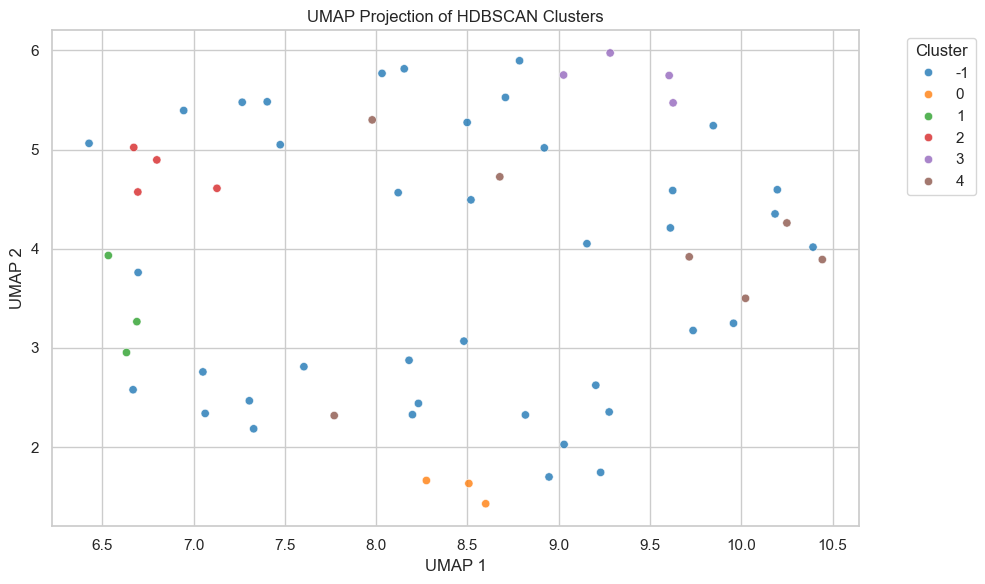

In [40]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(X_reduced.drop(columns=["kmeans_cluster", "hdbscan_cluster"]))

# Add coordinates back to the DataFrame
X_reduced["umap_x"] = X_umap[:, 0]
X_reduced["umap_y"] = X_umap[:, 1]

# Save UMAP coordinates and cluster labels to new CSV
X_reduced[["umap_x", "umap_y", "hdbscan_cluster"]].to_csv("../data/umap_projection.csv")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X_reduced,
    x="umap_x", y="umap_y",
    hue="hdbscan_cluster",
    palette="tab10",
    legend="full",
    alpha=0.8
)
plt.title("UMAP Projection of HDBSCAN Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Summarize Each Cluster

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Reload preprocessed text and cluster labels
df = pd.read_csv("../data/tickets_preprocessed.csv", index_col="ticket_id")
df["hdbscan_cluster"] = X_reduced["hdbscan_cluster"]

# Use the same TF-IDF vectorizer (you can load from joblib if needed)
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.95, min_df=2)
tfidf_matrix = vectorizer.fit_transform(df["processed_text"])
terms = vectorizer.get_feature_names_out()

# Summarize each cluster
for cluster_id in sorted(df["hdbscan_cluster"].unique()):
    if cluster_id == -1:
        continue  # Skip noise
    indices = df[df["hdbscan_cluster"] == cluster_id].index
    cluster_tfidf = tfidf_matrix[[i - 1 for i in indices]]  # adjust for ticket_id index
    mean_tfidf = np.asarray(cluster_tfidf.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[::-1][:10]
    keywords = [terms[i] for i in top_indices]
    
    print(f"\n--- Cluster {cluster_id}: Top Keywords ---")
    print(", ".join(keywords))


--- Cluster 0: Top Keywords ---
team, work, entry, multiple, mouse, monitor, lose, log, laptop, install

--- Cluster 1: Top Keywords ---
server, power, report, dashboard, rack, zone, error, monitor, lose, log

--- Cluster 2: Top Keywords ---
unable, rack, install, new, access, entry, mouse, monitor, lose, log

--- Cluster 3: Top Keywords ---
battery, laptop, zone, fail, entry, multiple, mouse, monitor, lose, log

--- Cluster 4: Top Keywords ---
multiple, run, receive, humidity, reading, pod, sensor, report, airflow, lose


# Export HDBSCAN Clusters and Summary Keywords

In [39]:
# Merge with original descriptions
df_full = df[["description", "processed_text", "hdbscan_cluster"]]
df_full.to_csv("../data/ticket_clusters_hdbscan.csv")

print("Saved ticket_clusters_hdbscan.csv")

Saved ticket_clusters_hdbscan.csv


In [36]:
# Cell 10B: Save top keywords per cluster

cluster_keywords = []

for cluster_id in sorted(df["hdbscan_cluster"].unique()):
    if cluster_id == -1:
        continue
    indices = df[df["hdbscan_cluster"] == cluster_id].index
    cluster_tfidf = tfidf_matrix[[i - 1 for i in indices]]
    mean_tfidf = np.asarray(cluster_tfidf.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[::-1][:10]
    keywords = [terms[i] for i in top_indices]
    cluster_keywords.append({
        "cluster": cluster_id,
        "keywords": ", ".join(keywords)
    })

# Save to CSV
keywords_df = pd.DataFrame(cluster_keywords)
keywords_df.to_csv("../data/cluster_keywords_hdbscan.csv", index=False)

print("Saved cluster_keywords_hdbscan.csv")


Saved cluster_keywords_hdbscan.csv
